In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import scipy
from scipy import signal
from scipy.io import loadmat
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Dense,Reshape,Dropout,Normalization,BatchNormalization,LayerNormalization,GroupNormalization,Add
from tensorflow.keras.layers import LSTM,GRU,Bidirectional
from tensorflow.keras.layers import Conv2D,DepthwiseConv2D,SeparableConvolution2D,MaxPooling2D,AveragePooling2D,Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

Mounted at /content/drive


### **Load and Preprocess Data**

In [2]:
# Define filter parameters for different frequency bands
filters = {
    'theta': (4, 8, 751),
    'alpha': (8, 12, 375),
    'beta': (12, 30, 251),
    'gamma': (30, 50, 101)
}
# Set sampling frequency
fs = 1000

def load_and_filter_data(patient_id, filter):
    """
    Load patient data and apply bandpass filters

    Parameters:
        patient_id (str): Identifier for the patient data file
        filter (dict): Dictionary with frequency bands and filter parameters

    Returns:
        dict: Filtered data by frequency band for a specific patient
    """

    fingerflex = loadmat(f'.../{patient_id}_fingerflex.mat')
    stim = loadmat(f'.../{patient_id}_stim.mat')

    elec_regions = fingerflex['elec_regions'] + 1
    data_full = fingerflex['data'].T
    stim = stim['stim'].squeeze()

    filtered_data = {}
    for band, (low, high, numtaps) in filter.items():
        filt_coef = signal.firwin(numtaps, cutoff=(low, high), fs=fs, pass_zero=False)
        filtered = np.array([np.convolve(ch, filt_coef, mode='same') for ch in data_full[elec_regions[:, 0] == 1]])
        filtered_data[band] = filtered
    filtered_data['stim'] = stim
    return filtered_data

# Initialize data dictionary
data = {band: {} for band in filters.keys()}
data['stim'] = {}
patient_id_list = ['wc', 'cc', 'jp']

for patient_id in patient_id_list:
    patient_data = load_and_filter_data(patient_id, filters)
    for key, value in patient_data.items():
      # First 4 keys are bandpass filtered data, last key is 'stim' data
      data[key][patient_id] = value

# Print data structure
print(f"Top Level Keys: {data.keys()}")
print(f"Second Level Keys: {data['theta'].keys()}")
print(f"Example Patient Data Size: {data['theta']['cc'].shape}")

Top Level Keys: dict_keys(['theta', 'alpha', 'beta', 'gamma', 'stim'])
Second Level Keys: dict_keys(['wc', 'cc', 'jp'])
Example Patient Data Size: (14, 610040)


### **Collect Finger Movement Data and Create 3D Dataset**

In [3]:
def index_positions(data):
    """
    Generate index positions for extracting epochs with a half-second overlap

    Parameters:
    - data (array) : The input data array to be indexed

    Returns :
    - array : An array of starting index positions for epochs with a half-second overlap
    """
    last_step = int(np.floor(len(data.T)/fs))
    time_steps_array = np.arange(0,last_step,0.5)
    indices = ((time_steps_array[time_steps_array < time_steps_array[-1]])*fs).astype(int)
    return indices

# Patient dataset filter bank
fingers = np.arange(0, 6)
theta_patient_data = [data['theta'][id] for id in patient_id_list]
alpha_patient_data = [data['alpha'][id] for id in patient_id_list]
beta_patient_data = [data['beta'][id] for id in patient_id_list]
gamma_patient_data = [data['gamma'][id] for id in patient_id_list]
stims = [data['stim'][id] for id in patient_id_list]

def patient_finger_data(fingers,patients,stims,fs=fs):
    """
    Collect and output a 3D dataset of each finger movement across all patients

    Parameters:
    - fingers (list of int): List of finger indices to process, including rest (e.g., 0-5)
    - patients (list of arrays): List containing data arrays for each patient,
      with each array shaped (electrodes, data points)
    - stims (list of arrays): List containing stim variable for each patient's data,
      stim contains finger movement indices at each data point
    - fs (int): Sampling frequency

    Returns:
    - List of arrays: Contains 3D arrays, each corresponding to a finger movement's
      data across patients. Each array is shaped (epochs, electrodes, data points)
    """

    all_finger_data = [] # Stores processed data for each finger movement across all patients

    for i in fingers:
        finger_epochs = [] # Stores data for current finger movement data across all patients

        for stim,patient in zip(stims,patients):
            len_win = 1 # Window length in seconds
            finger_data = patient[0:8, stim == i] # Extract data for the current finger
            indices = index_positions(finger_data)

            # Segment data into epochs of length 'len_win' (1 second) and store
            epochs = np.array([finger_data[:, index:index + int(len_win*fs)] for index in indices])
            finger_epochs.append(epochs)

        # Combine epochs across all patients for the current finger
        finger_data = np.concatenate(finger_epochs, axis=0)

        # Min/max normalization (without shift)
        finger_data /= (np.max(abs(finger_data)) - np.min(abs(finger_data)))

        # Apply rFFT to each channel within each epoch and store power spectrum
        finger_data = np.array([[np.abs(scipy.fft.rfft(ch))**2 for ch in epoch] for epoch in finger_data])

        all_finger_data.append(finger_data)

    return all_finger_data

# Load dictionary with finger movement dataset filter bank
Data = {}
filtered_patient_data = [theta_patient_data, alpha_patient_data, beta_patient_data, gamma_patient_data]
for i,band in enumerate(filters.keys()):
    Data[band] = patient_finger_data(fingers,filtered_patient_data[i],stims)

str = ['Rest Data Shape','Thumb Data Shape','Index Data Shape','Middle Data Shape','Ring Data Shape', 'Pinky Data Shape']
for label,d_ in zip(str,Data['theta']):
    print(f'{label}:{d_.shape}')

Rest Data Shape:(531, 8, 501)
Thumb Data Shape:(501, 8, 501)
Index Data Shape:(497, 8, 501)
Middle Data Shape:(397, 8, 501)
Ring Data Shape:(495, 8, 501)
Pinky Data Shape:(463, 8, 501)


### **Create Train and Test Sets**

In [4]:
# Concatenate all finger movement data for each filtered set
theta_finger_data = np.concatenate(Data['theta'], axis=0)
alpha_finger_data = np.concatenate(Data['alpha'], axis=0)
beta_finger_data = np.concatenate(Data['beta'], axis=0)
gamma_finger_data = np.concatenate(Data['gamma'], axis=0)

# Stack data along a new dimension, final shape is (epochs,electrodes,data points,channels)
X = np.stack([theta_finger_data,alpha_finger_data,beta_finger_data,gamma_finger_data], axis=3)
print(f'X shape:{X.shape}')

# Create Y target variable with labels for either rest (0) or finger movement (1-5)
Y = np.concatenate([np.full(Data['theta'][i].shape[0],i) for i in range(6)])[:,np.newaxis]
print(f'Y shape:{Y.shape}')

x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

print(f'x_train shape:{x_train.shape} \nx_test shape:{x_test.shape} \ny_train shape:{y_train.shape} \ny_test shape:{y_test.shape}')

X shape:(2884, 8, 501, 4)
Y shape:(2884, 1)
x_train shape:(2307, 8, 501, 4) 
x_test shape:(577, 8, 501, 4) 
y_train shape:(2307, 1) 
y_test shape:(577, 1)


### **Build ResConv - BiLSTM Model**

In [5]:
def residual_block(input, conv_filters, kernel_size, depth_multiplier):
    """
    Create a residual block with Conv2D, DepthwiseConv2D, and a skip connection

    Parameters:
    - input (array): Input array for the residual block
    - conv_filters (int): Number of filters for the Conv2D layer
    - kernel_size (tuple): Kernel size for the Conv2D layer (e.g., (1, 125))
    - depth_multiplier (int): Depth multiplier for the DepthwiseConv2D layer

    Returns:
    - tensor: Output tensor after the residual block
    """
    # Save input for residual connection
    residual = input

    # First Conv2D layer
    conv_output = Conv2D(conv_filters, kernel_size, activation='relu', padding='same')(input)
    conv_output = BatchNormalization()(conv_output)

    # DepthwiseConv2D layer
    depthwise_output = DepthwiseConv2D((8,1),
                        depth_multiplier=depth_multiplier,
                        activation='relu',
                        padding='same')(conv_output)
    depthwise_output = BatchNormalization()(depthwise_output)


    # If the residual has fewer filters/feature maps, apply a 1x1 convolution to match the number of filters
    if residual.shape[-1] != depthwise_output.shape[-1]:
        residual = Conv2D(depthwise_output.shape[-1],(1,1),activation='relu', padding='same')(residual)

    # Add the residual back to the output
    output = Add()([depthwise_output, residual])

    return output

def ResConv_BiLSTM(x_train=x_train):
    """
    Build a Residual Convolutional Network with Bidirectional LSTM model

    Parameters:
    - x_train (array): Training dataset with shape
                       (electrodes, data points, channels)

    Returns:
    - Model: Compiled Keras model
    """
    input_layer = Input(shape=(x_train.shape[1:]))

    # Initial Conv2D layer
    conv_initial = Conv2D(8, (1,125), activation='relu', padding='same')(input_layer)
    conv_initial = BatchNormalization()(conv_initial)

    # First residual block
    residual_output_1 = residual_block(conv_initial, 16, kernel_size=(1,125), depth_multiplier=1)
    pooled_output_1 = AveragePooling2D((1,4))(residual_output_1)
    dropout_1 = Dropout(0.2)(pooled_output_1)

    # Second Conv2D layer
    conv_second = Conv2D(32,(1,62), activation='relu', padding='same')(dropout_1)
    conv_second = BatchNormalization()(conv_second)

    # Second residual block
    residual_output_2 = residual_block(conv_second, 64, kernel_size=(1,62), depth_multiplier=2)
    pooled_output_2 = AveragePooling2D((1,4))(residual_output_2)
    dropout_2 = Dropout(0.2)(pooled_output_2)

    # Reshape and pass through BiLSTM layer
    reshaped_output = Reshape((x_train.shape[1], -1))(dropout_2)
    lstm_output = Bidirectional(LSTM(128))(reshaped_output)
    dropout_3 = Dropout(0.3)(lstm_output)

    # Output layer
    output_layer = Dense(6)(dropout_3)

    return Model(input_layer, output_layer)

### **Build Shallow CNN Model**

In [6]:
def shallow_CNN(x_train=x_train):
    """
    Build a shallow CNN model for comparison

    Parameters:
    - x_train (array): Training dataset with shape
                       (electrodes, data points, channels)

    Returns:
    - Model: Keras Sequential model object
    """

    model2 = Sequential([
        Input(shape=(x_train.shape[1:])),

        # First Conv2D layer
        Conv2D(8, (1,250), activation='relu',padding='same'),
        BatchNormalization(),

        # Second Conv2D layer
        Conv2D(16, (1,125), activation='relu',padding='same'),
        BatchNormalization(),
        AveragePooling2D((1,2)),

        # Flatten and output layer
        Flatten(),
        Dense(6)
    ])

    return model2

### **Build Simple LSTM Model**

In [7]:
def simple_LSTM(x_train=x_train):
    """
    Build a simple LSTM model for comparison

    Parameters:
    - x_train (array): Training dataset with shape
                       (electrodes, data points, channels)

    Returns:
    - Model: Keras Sequential model object
    """

    model3 = Sequential([
      Input(shape=(x_train.shape[1:])),
      Reshape((x_train.shape[1],-1)),

      # LSTM layers
      LSTM(64, return_sequences=True),
      BatchNormalization(),

      LSTM(128, return_sequences=True),
      BatchNormalization(),

      LSTM(256),
      BatchNormalization(),
      Dropout(0.2),

      # Output layer
      Dense(6)
  ])

    return model3

### **Build SVM Model**

In [8]:
def SVM():
    """
    Build a Support Vector Machine (SVM) model for comparison

    Returns:
    - SVC: Scikit-learn's SVC model object with RBF kernel
    """
    return SVC(kernel='rbf')

# Flatten last 3 dimensions (electrodes * data points * channels) of dataset into a single feature vector
x_train_svm = x_train.reshape((x_train.shape[0],-1))
x_test_svm = x_test.reshape((x_test.shape[0],-1))
y_train_svm,y_test_svm = y_train.squeeze(),y_test.squeeze()


### **Test Each Model**

In [32]:
# Load dictionary with models
models = {'ResConv - BiLSTM': ResConv_BiLSTM(),
          'CNN': shallow_CNN(),
          'LSTM': simple_LSTM(),
          'SVM': SVM()
          }

# Create another dictionary to store performance metrics for each model
metrics=['Accuracy','Precision','Recall','F1']
results = {metric:[] for metric in metrics}

# Function that executes each metric
def metric_functions(y_test,y_predict):
  functions = {
      'Accuracy' : accuracy_score(y_test, y_predict)*100,
      'Precision' : precision_score(y_test, y_predict, average='weighted', zero_division=0)*100,
      'Recall' : recall_score(y_test, y_predict, average='weighted')*100,
      'F1' : f1_score(y_test, y_predict, average='weighted')*100
  }
  return functions

# Loop through each model type
for model_type, (model) in models.items():
  if model_type != 'SVM':
    tf.random.set_seed(1234)

    model.compile(
        optimizer = Adam(0.001),
        loss = SparseCategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    model.fit(
        x_train,y_train,
        epochs = 80,
        verbose = 0
    )
    y_predict_nn = np.argmax(tf.nn.softmax(model.predict(x_test)),axis=1)

    for metric,metric_func in metric_functions(y_test,y_predict_nn).items():
      results[metric] += [metric_func]

  else:
    model.fit(x_train_svm,y_train_svm)
    y_predict = model.predict(x_test_svm)

    for metric,metric_func in metric_functions(y_test,y_predict).items():
      results[metric] += [metric_func]

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


### **Plot and Compare All Models**

                  Accuracy  Precision  Recall     F1
ResConv - BiLSTM     90.81      91.06   90.81  90.82
CNN                  77.30      78.16   77.30  76.80
LSTM                 66.03      66.70   66.03  66.03
SVM                  64.82      65.62   64.82  64.44 



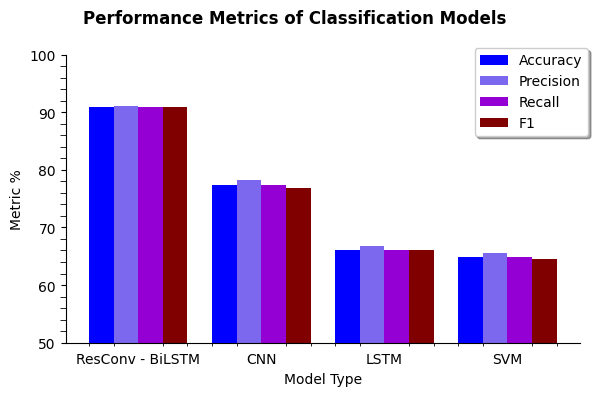

In [33]:
# Convert data into a pandas DataFrame
metric_df = pd.DataFrame(data=results, index=list(models.keys()))
print(f'{metric_df.round(2)} \n')

# Create a bar plot
fig, ax = plt.subplots(figsize=(6,4))

model_names = list(models.keys())
bar_width = 0.2
index = np.arange(len(model_names))
colors = ['blue','mediumslateblue','darkviolet','maroon']

# Loop over each metric and plot
for i, metric in enumerate(metrics):
    ax.bar(index + i*bar_width, metric_df.iloc[:,i], bar_width, color=colors[i], label=metric)


ax.set(xlabel = 'Model Type', ylabel = 'Metric %')
ax.set(ylim=[50,100], yticks=np.arange(50,101,10))

ax.minorticks_on()
ax.tick_params(axis='x',bottom=False)
ax.tick_params(axis='y',which='minor',length=4,color='black')
ax.set_xticks(index + 0.3, model_names)

sns.despine(fig,top=True,right=True)
fig.legend(loc = 'upper right', shadow=True, bbox_to_anchor=(1.0,0.9))
fig.suptitle('Performance Metrics of Classification Models', fontweight='bold')

plt.tight_layout()
plt.show()

### **Save the Model**

In [64]:
models["ResConv - BiLSTM"].save('finger_movement_classification_model.keras')